# Attack attempt, training both G and D in the GAN, using all classes to train the G

First attempt at training the GAN D/G to provide **valid** and **representable** data from unknown classes

## Imports

In [1]:
import tensorflow as tf
# tf.enable_eager_execution() # default for TF 2.0

tf.keras.backend.clear_session()  # For easy reset of notebook state.
from tensorflow import keras  # Import the tf version of keras.
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, \
                                    LeakyReLU, Conv2DTranspose, Reshape
# import keras.backend as K
from tensorflow.keras.datasets import mnist

print('TF', tf.__version__)
print('Keras', keras.__version__)

TF 2.1.0
Keras 2.2.4-tf


In [2]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tqdm
import pickle
from glob import glob
from pprint import pprint

import os.path
import shutil
import math
import random
from copy import copy, deepcopy

In [3]:
# Setting seeds for reproducibility 
np.random.seed(0)
tf.random.set_seed(0)

# Enlargen plots
plt.rcParams['figure.figsize'] = [10, 5]

## Parameters

In [4]:
# EASY_MODE: if True, Split Learning NN is used as the Discriminator in the GAN. This is good for testing, but
# bypasses the black-box paradigm! Use with caution
EASY_MODE = True

# Black-box params (optimized for MNIST)
depth = 9
filters = 33
dense = 110
num_classes = 10

# Input image dimensions
img_rows, img_cols = 28, 28
target_rows, target_cols = 28, 28    # governed by the chosen model
input_shape = (target_rows, target_cols, 1)

# Attack params:
attack_params = {
    'our_class': 0,                             # the label indices that we want to preserve (and the data we own)
    'attacker_clients': 1,                      # attacker controls X number of clients and their data
    'attack_classes': [1],                      # the label(s) we want to poison
    'flip_to': [7],                             # must be len(attack_classes) - flips the target label ('1') to new class ('7')
    'gan_trigger': 0.13,                        # the D test accuracy that, after which, we will commence GAN training
    'attack_trigger': 0.8,                      # the D accuracy (wrt Black-box) that, after which, we will commence an attack
    'd_refinement_batch_num': 1,                # number of batches to refine D with: G -> BB <-> D
    'd_refinement_batch_size': 256,             # number of attack images to refine D with: G -> BB <-> D
    'train_dataset': None,                      # attack dataset - fixed in the beginning by choosing the attacking clients
                                                # - this is the only data we have access to throughout the training process
    'attacks_per_epoch': 10,                    # how many times to attack per epoch
    'd_refine_trigger': 1.0,                    # how good D has to be on the current blackbox model to continue
}

# Split Learning training params:
split_training_params = {
    'minibatch_size': None,                     # number of samples to operate on at one time
                                                #  - can vary to optimize computing requirements
                                                #  - if None, will evaluate the client's whole batch regardless of its size
    'apply_gradients_after': 20,                # after averaging the gradients from X clients, we will apply them to the model
    'epochs': 1,                                # number of epochs to train for
    'shuffle_clients': True,                    # whether to shuffle the clients during training
    'eval_batch_size': 256,                     # batch size when evaluating test set (not split by clients),
    'train_dataset': None,                      # training set - indexed by client
    'test_dataset': None,                       # testing set - not batched
    'ckpt_folder': "blackbox_checkpoint",       # folder where to store the checkpoints
}

# GAN training params:
gan_training_params = {
    'minibatch_size': split_training_params['minibatch_size'],
    'batch_size': 256,                          # number of images to generate from G at once
    'noise_dim': 100,                           # noise vector for G
    'epochs': 1500,                             # number of epochs to train GAN
    'use_blackbox': False,                      # if True, copies the Blackbox model into D (easy check)
    'd_ckpt_folder': "discriminator_checkpoint",# folder where to store the d checkpoints
    'bb_ckpt_folder': "blackbox_checkpoint",    # folder where the blackbox default ckpt is kept
    'g_ckpt_folder': "generator_checkpoint",    # folder where to store the g checkpoints
    'batches_per_epoch': 100,                   # number of batches to train on per epoch
    'd_trigger': 0.98,                          # train D if g_accuracy is >= X
    'g_trigger': 1.01,                          # train G if g_accuracy is < X
    'loop_times': 0,                            # number of times to apply softmax -> onehot encoding
    'softmax_power': 4,                         # number used in softmax -> onehot encoding operation
    'd_reset_percentage': 1.0,                  # reset D if the test d_accuracy dips below X% of the original accuracy
    'early_stop_trigger': 5,                    # stop training early, if g_accuracy has not improved for X epochs
    'stop_sensitivity': 0.05,                   # "no improvement" is when the g_accuracy has not moved more than X% from prev
    'g_nudge_trigger': 3,                       # if "no improvement" for X epochs, turn on D for one turn
    'g_nudge_probability': 0.20,                # probability of nudging this sample, if enabled
}

# Data parsing params
clients_per_class = 100                         # number of clients per label. Each client only has access to one label
                                                # - each unique class is divided into X number of subsets

# Dataset params
separated_folder = "./separated_dataset"
os.makedirs(separated_folder, exist_ok=True)
separated_train_path = os.path.join(separated_folder, "train_separated.pkl")
separated_test_path = os.path.join(separated_folder, "test_separated.pkl")

## Load Data

In [5]:
# The data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255    # range is [0, 1]
x_test /= 255     # range is [0, 1]

if target_rows != img_rows or target_cols != img_cols:
    # resize x_train
    x_train_resized = []
    for x_ in x_train:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_train_resized.append(x_)
    x_train = np.asarray(x_train_resized)

    # resize x_test
    x_test_resized = []
    for x_ in x_test:
        # scale image to be the same WxH as we need:
        x_ = cv2.resize(x_, dsize=(target_rows, target_cols), interpolation=cv2.INTER_CUBIC)
        x_test_resized.append(x_)
    x_test = np.asarray(x_test_resized)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [6]:
# summary of data shapes:
print('X:', x_train.shape, x_test.shape)
print('y:', y_train.shape, y_test.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

BUFFER_SIZE = x_train.shape[0]

X: (60000, 28, 28, 1) (10000, 28, 28, 1)
y: (60000, 10) (10000, 10)
60000 train samples
10000 test samples


#### Separate the data by class

In [7]:
# Separating the data by class
if os.path.isfile(separated_train_path):
    with open(separated_train_path, 'rb') as f:
        x_train_dict, y_train_dict = pickle.load(f)
        print('loaded training seperation')
else:
    x_train_dict = {}
    y_train_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_train_dict[target_label] = []
        y_train_dict[target_label] = []
        for i, label in enumerate(y_train):
            if list(label).index(1) == target_label:
                x_train_dict[target_label].append(x_train[i])
                y_train_dict[target_label].append(y_train[i])
    
    with open(separated_train_path, 'wb') as f:
        pickle.dump([x_train_dict, y_train_dict], f)
        print('saved training seperation')

if os.path.isfile(separated_test_path):
    with open(separated_test_path, 'rb') as f:
        x_test_dict, y_test_dict = pickle.load(f)
        print('loaded testing seperation')
else:
    x_test_dict = {}
    y_test_dict = {}
    for target_label in tqdm_notebook(range(10)):
        x_test_dict[target_label] = []
        y_test_dict[target_label] = []
        for i, label in enumerate(y_test):
            if list(label).index(1) == target_label:
                x_test_dict[target_label].append(x_test[i])
                y_test_dict[target_label].append(y_test[i])

    with open(separated_test_path, 'wb') as f:
        pickle.dump([x_test_dict, y_test_dict], f)
        print('saved testing seperation')
    
# convert dicts to lists
x_train_seperated = [np.array(x_train_dict[i]) for i in range(10)]
y_train_seperated = [np.array(y_train_dict[i]) for i in range(10)]

x_test_seperated = [np.array(x_test_dict[i]) for i in range(10)]
y_test_seperated = [np.array(y_test_dict[i]) for i in range(10)]

loaded training seperation
loaded testing seperation


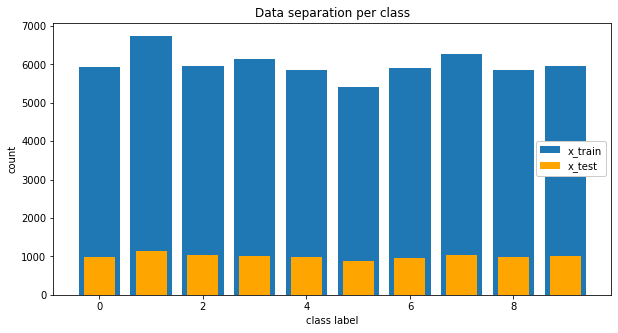

In [8]:
# summary of data shapes:
plt.figure()
plt.title('Data separation per class')
plt.bar(x_train_dict.keys(), [len(v) for v in x_train_dict.values()], color='tab:blue')
plt.bar(x_test_dict.keys(), [len(v) for v in x_test_dict.values()], color='orange', width=0.6)
plt.legend(['x_train', 'x_test'], loc='center right', framealpha=1.0)
plt.xlabel('class label')
plt.ylabel('count')
plt.show()

#### Separate the data into batches for clients to use

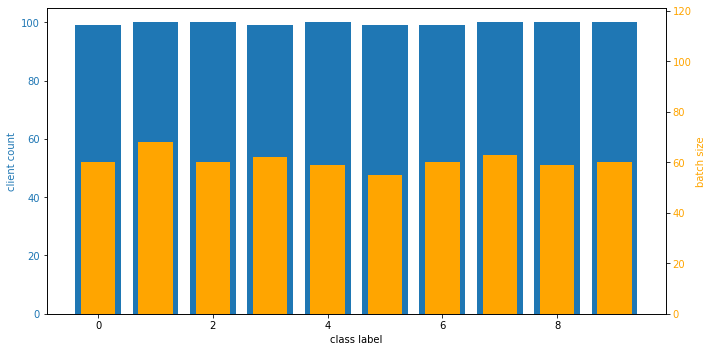

Clients per class:  99.6 ~= 100
Total number of clients: 996
Average batch size: 60.6


In [9]:
# Separate the data into a long list of batches, each batch representing a client training with that batch of images.
# After each batch, a new client will have the opportunity to train their batch of images.
# Batches are shuffled to simulate many clients training the model at once.

client_counts = {}
batch_sizes = {}
x_batches = []
y_batches = []

def ceil(a,b):
    return -(-a//b)

for class_idx in range(len(x_train_seperated)):
    # Get batches from class data:
    n_samples_per_class = len(x_train_seperated[class_idx])
    samples_per_client = n_samples_per_class / clients_per_class
    better_batch_size = int(math.ceil(samples_per_client))

    count = 0
    for i in range(ceil(n_samples_per_class, better_batch_size)):
        x_batches.append((class_idx, x_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        y_batches.append((class_idx, y_train_seperated[class_idx][i * better_batch_size: (i+1) * better_batch_size]))
        count += 1
    client_counts[class_idx] = count
    batch_sizes[class_idx] = better_batch_size
        
# double check that the clients_per_class is upheld per class
# (blue bars should be uniform, orange should change according to class):
fig, ax1 = plt.subplots()

color = 'tab:blue'
ax1.set_xlabel('class label')
ax1.set_ylabel('client count', color=color)
plt.bar(client_counts.keys(), [v for v in client_counts.values()], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'orange'
ax2.set_ylabel('batch size', color=color)  # we already handled the x-label with ax1
plt.bar(batch_sizes.keys(), [v for v in batch_sizes.values()], color=color, width=0.6)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(0, np.mean([v for v in batch_sizes.values()])*2)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

print('Clients per class:  {} ~= {}'.format(np.mean([v for v in client_counts.values()]), clients_per_class))
print('Total number of clients: {}'.format(np.sum([v for v in client_counts.values()])))
print('Average batch size: {}'.format(np.mean([v for v in batch_sizes.values()])))

split_batch_size = np.floor(np.mean([v for v in batch_sizes.values()]))

#### Define the attacker's dataset

In [10]:
x_batches_filtered_i = [i for i, batch in enumerate(x_batches) if batch[0] == attack_params['our_class']]
y_batches_filtered_i = [i for i, batch in enumerate(y_batches) if batch[0] == attack_params['our_class']]
assert x_batches_filtered_i == y_batches_filtered_i

x_batches_filtered = list(map(x_batches.__getitem__, x_batches_filtered_i))
y_batches_filtered = list(map(y_batches.__getitem__, y_batches_filtered_i))

print('{} clients to choose from:'.format(len(x_batches_filtered)))
print('Classes of attack clients:', [f[0] for f in x_batches_filtered])
print()

attack_clients = np.random.choice(len(x_batches_filtered), attack_params['attacker_clients'], replace=False)
print('Choosing the following clients as the attackers:\n{}'.format(attack_clients))
x_attack_batches = list(map(x_batches_filtered.__getitem__, attack_clients))
y_attack_batches = list(map(y_batches_filtered.__getitem__, attack_clients))

99 clients to choose from:
Classes of attack clients: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Choosing the following clients as the attackers:
[26]


In [11]:
# remove the attackers from the original training dataset
# BREAKS THE ORIGINAL X_BATCHES AND Y_BATCHES!
print('Original dataset length:', len(x_batches), len(y_batches))

x_attackers_i = list(map(x_batches_filtered_i.__getitem__, attack_clients))
y_attackers_i = list(map(y_batches_filtered_i.__getitem__, attack_clients))

x_batches = [batch for i, batch in enumerate(x_batches) if i not in x_attackers_i]
y_batches = [batch for i, batch in enumerate(y_batches) if i not in y_attackers_i]

print('New dataset length:     ', len(x_batches), len(y_batches))

Original dataset length: 996 996
New dataset length:      995 995


#### Define our datasets

In [12]:
# Batch and shuffle the data for Split Learning
split_train_dataset = (x_batches, y_batches)
split_test_dataset = (x_test, y_test)

# place into train params:
split_training_params['train_dataset'] = split_train_dataset
split_training_params['test_dataset'] = split_test_dataset

# Build attack dataset
attack_train_dataset = (x_attack_batches, y_attack_batches)
attack_params['train_dataset'] = attack_train_dataset

In [13]:
# Show min and max of the dataset (ensure you are using the right normalization)
min_ = np.inf
max_ = -np.inf
for batch in x_batches:
    min__ = np.min(batch[1])
    max__ = np.max(batch[1])
    min_ = min(min_, min__)
    max_ = max(max_, max__)
print('Min: {}; Max: {}'.format(min_, max_))

Min: 0.0; Max: 1.0


## Build Model

In [14]:
# FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=

def start_piece_(input_shape, filters=4):
    assert filters >= 1
    
    model = tf.keras.Sequential()
    model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
    
    return model

def blackbox_piece_(model, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    # for now, we will just give the black-box all the CNN layers
    for i in range(depth-1):
        model.add(Conv2D(filters, kernel_size=(3, 3), activation='relu', padding='same'))
    
    return model

def approximator_piece_(model, depth=1, filters=4):
    assert depth >= 1
    assert filters >= 1
    
    # for now, we will just give the approximator_piece piece the same complexity as bb (since we have shown it doens't matter)
    model = blackbox_piece_(model, depth, filters)
    
    return model

def end_piece_(model, dense_breadth=128, num_classes=10):
    assert dense_breadth >= num_classes
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(dense_breadth, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

## Graph Creation

In [15]:
# Ensure the params are acceptable:
assert depth >= 1
assert filters >= 1
assert dense >= num_classes

In [16]:
class SplitLearning:
    
    def __init__(self, split_training_params):
        self.minibatch_size = split_training_params['minibatch_size']
        self.batches_per_train_step = split_training_params['apply_gradients_after']
        self.eval_batch_size = split_training_params['eval_batch_size']
        self.shuffle_clients = split_training_params['shuffle_clients']
        self.ckpt_folder = split_training_params['ckpt_folder']
        
        # define the NN model
        self.model = self.blackbox_model()
        
        # define loss function
        self.cross_entropy = keras.losses.CategoricalCrossentropy(from_logits=True)
        
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define metrics
        self.acc_train_avg = None
        self.loss_train_avg = None
        
        # setup checkpointing
        self.init_ckpt()
        
        # setup ops
        self.setup_ops()
        
    ###########################################################################################
    # Black-box model
        
    def blackbox_model(self):
        model = start_piece_(input_shape, filters)
        model = blackbox_piece_(model, depth, filters)
        model = end_piece_(model, dense, num_classes)
        return model
    
    def model_loss(self, y_true, y_pred):
        return self.cross_entropy(y_true, y_pred)
        
    ###########################################################################################
    # Train
    
    def setup_ops(self):
        # INSPIRED BY: https://stackoverflow.com/questions/42156957/how-to-update-model-parameters-with-accumulated-gradients
        # https://www.tensorflow.org/tutorials/customization/custom_training_walkthrough
        
        self.tvs = self.model.trainable_variables
        self.accum_vars = [tf.Variable(tf.zeros_like(tv.initialized_value()), trainable=False) for tv in self.tvs]
        self.accum_counter = tf.Variable(0.0, trainable=False)
    
    def train(self, datasets, iteration, g_dataset=None):
        # setup checkpointing
        self.setup_ckpt(iteration)
        
        # setup bb_dataset (stores labels if g_dataset is passed in)
        bb_dataset = []
        
        # initialize the metrics each new epoch
        if self.acc_train_avg is not None:
            del self.acc_train_avg
        if self.loss_train_avg is not None:
            del self.loss_train_avg
        self.acc_train_avg = tf.keras.metrics.Accuracy()
        self.loss_train_avg = tf.keras.metrics.Mean()
        
        # append all datasets together for training:
        x_batches = []
        y_batches = []
        for dataset in datasets:
            x_batches_, y_batches_ = dataset
            x_batches = x_batches + x_batches_
            y_batches = y_batches + y_batches_
        # if g_dataset is not None, add those batches to the end:
        if g_dataset is not None:
            g_x_batches, g_y_batches = g_dataset
            g_batch_idxs = list(range(len(x_batches), len(x_batches)+len(g_x_batches)))
            x_batches = x_batches + g_x_batches
            y_batches = y_batches + g_y_batches
        else:
            g_batch_idxs = []
            
        # setup progress bar
        pbar = tqdm_notebook(total=len(x_batches))
        
        batch_idxs = list(range(len(x_batches)))
        if self.shuffle_clients:
            # shuffle the batches each time
            random.shuffle(batch_idxs)
            
        for i, batch_idx in enumerate(batch_idxs):
            x_batch = x_batches[batch_idx][1]
            y_batch = y_batches[batch_idx][1]
            
            if batch_idx in g_batch_idxs:
                # this is a g_x_batch! don't apply gradients, but store the prediction
                logit_batch = self.pred_step(x_batch)
                bb_dataset.append((x_batch, y_batch, logit_batch))
            else:
                self.train_step(i, x_batch, y_batch, len(batch_idxs) - 1)
            pbar.update(1)
            pbar.set_description('train_acc={:.2f}%'.format(self.acc_train_avg.result()*100))
        pbar.close()
        
        # save checkpoints
        self.checkpoint()
        
        return bb_dataset
        
    def pred_step(self, x_batch):
        logit_batch = None
        # Iterate over the client's batch in minibatches:
        j = 0
        while(j < len(x_batch)):
            if self.minibatch_size is None:
                # use whole batch (no minibatch)
                x_minibatch = x_batch
                y_minibatch = y_batch
            else:
                x_minibatch = x_batch[j:(j+self.minibatch_size)]
                y_minibatch = y_batch[j:(j+self.minibatch_size)]

            logits = self.model(x_minibatch, training=True) # TODO: should this be False?
            if logit_batch is None:
                logit_batch = logits.numpy()
            else:
                logit_batch.concat(logits.numpy(), axis=0)

            if self.minibatch_size is None:
                break
            else:
                j += self.minibatch_size
                
        return logit_batch
        
    def train_step(self, i, x_batch, y_batch, limit):
        # Iterate over the client's batch in minibatches:
        j = 0
        while(j < len(x_batch)):
            if self.minibatch_size is None:
                # use whole batch (no minibatch)
                x_minibatch = x_batch
                y_minibatch = y_batch
            else:
                x_minibatch = x_batch[j:(j+self.minibatch_size)]
                y_minibatch = y_batch[j:(j+self.minibatch_size)]

            # run the gradients
            loss_value, grads = self.grad(x_minibatch, y_minibatch)

            # accumulate them
            self.accumulate_grads(grads)

            if self.minibatch_size is None:
                break
            else:
                j += self.minibatch_size

        # perform a train step every batches_per_train_step number of batches:
        if (i > 0 and i % self.batches_per_train_step == 0) or i == limit:
            # Run the train_step ops to update the weights based on our accumulated gradients
            self.optimize()
            self.zero_out()
    
    def grad(self, inputs, targets):
        with tf.GradientTape() as tape:
            logits = self.model(inputs, training=True)
            loss_value = self.model_loss(targets, logits)
            
        # evaluate accuracy and append acc and loss to arrays
        self.acc_train_avg(tf.argmax(targets, 1), tf.argmax(logits, 1))
        self.loss_train_avg(loss_value)
        
        return loss_value, tape.gradient(loss_value, self.model.trainable_variables)
    
    def accumulate_grads(self, grads):
        # add to accum_vars the new gradients
        for i, grad in enumerate(grads):
            self.accum_vars[i].assign_add(grad)
        # increment the counter by 1
        self.accum_counter.assign_add(1.0)
        
    def optimize(self):
        # apply the gradients in accum_vars, dividing by the number in accum_counter
        self.optimizer.apply_gradients(
            [(accum_var / self.accum_counter, tv) \
                for (accum_var, tv) in zip(self.accum_vars, self.model.trainable_variables)]
        )
    
    def zero_out(self):
        # reset accum_vars and accum_counter back to 0
        for i, tv in enumerate(self.accum_vars):
            self.accum_vars[i].assign(tf.zeros_like(tv))
        self.accum_counter = tf.Variable(0.0, trainable=False)
        
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        self.manager = None
        self.internal_iteration = None
        self.iteration_offset = 0
        
    def setup_ckpt(self, iteration):
        # setup fresh checkpointer every new iteration
        if self.internal_iteration is None or iteration != self.internal_iteration - self.iteration_offset:
            ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration + self.iteration_offset), self.ckpt_folder)
            os.makedirs(ckpt_save_folder, exist_ok=True)
        
            if self.ckpt is not None:
                del self.ckpt
            if self.manager is not None:
                del self.manager

            self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
            self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
            self.internal_iteration = iteration + self.iteration_offset
    
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved checkpoint: {}".format(save_path))
        
    def restore(self, it_restore=None, load_default=False):
        parent_folder = os.path.join('checkpoints')
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                self.iteration_offset = largest_it
                print('Restored latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found, starting with a fresh network')
        else:
            if load_default:
                checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    self.iteration_offset = it_restore
                print('Restored latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        
    ###########################################################################################
    # Evaluate
        
    def evaluate(self, dataset):
        '''
        NOTE: dataset here is tailored for standard 'test' dataset provided by Keras
        '''
        
        x, y = dataset
        
        acc_test_avg = tf.keras.metrics.Accuracy()
        loss_test_avg = tf.keras.metrics.Mean()
        for i in range(0, len(x), self.eval_batch_size):
            # get batch
            x_batch = x[i:i+self.eval_batch_size]
            y_batch = y[i:i+self.eval_batch_size]
            
            # evaluate
            logits = self.model(x_batch, training=False)
            acc_test_avg(tf.argmax(y_batch, 1), tf.argmax(logits, 1))
            loss_test_avg(self.model_loss(y_batch, logits))
        
        if self.acc_train_avg is not None and self.loss_train_avg is not None:
            print('Train Accuracy: {:.3f} | Loss: {:.3f}'.format(self.acc_train_avg.result(), self.loss_train_avg.result()))
        print('Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test_avg.result(), loss_test_avg.result()))
        print()
        
    def predict(self, dataset, return_tensors=True):
        '''
        Returns a list of label minibatches (list of lists) from each client that was in the dataset
        '''
        
        x, _ = dataset
        labels = []
        
        for i, client_x in enumerate(x):
            x_batch = client_x[1]
            label_batch = []
            
            # run through every minibatch:
            j = 0
            while(j < len(x_batch)):
                if self.minibatch_size is None:
                    # use whole batch (no minibatch)
                    x_minibatch = x_batch
                else:
                    x_minibatch = x_batch[j:(j+self.minibatch_size)]
                    
                # evaluate
                preds = self.model(x_batch, training=False)
                if not return_tensors:
                    preds = tf.nn.softmax(preds)
                    preds = tf.argmax(preds, axis=1).numpy()
                    
                label_batch.append(preds)
                
                if self.minibatch_size is None:
                    break
                else:
                    j += self.minibatch_size
            
            # add to dict
            labels.append(label_batch)
            
        return labels

In [17]:
class D:
    '''
    The Discriminator portion of the GAN. Accepts a network, otherwise creates a new model.
    '''
    
    def __init__(self, gan_training_params, discriminator=None):
        
        self.ckpt_folder = gan_training_params['d_ckpt_folder']
        self.bb_ckpt_folder = gan_training_params['bb_ckpt_folder']
        self.loop_times = gan_training_params['loop_times']
        self.softmax_power = gan_training_params['softmax_power']
        self.minibatch_size = gan_training_params['minibatch_size']
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        if discriminator is not None:
            self.model = discriminator
        else:
            self.model = self.discriminator_model()
            
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define entropies
        self.cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.bin_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            
        # setup checkpointing
        self.ckpt = None
        self.manager = None
        
    ###########################################################################################
    # Discriminator model
    
    def discriminator_model(self):
        model = start_piece_(input_shape, filters)
        model = approximator_piece_(model, depth, filters)
        model = end_piece_(model, dense, num_classes)
        return model
        
    ###########################################################################################
    # Loss
    
    def loss(self, fake_discrimination, labels):
        matches = self.matches_labels(fake_discrimination, labels, loop_times=self.loop_times)
        # we want the discriminator to NOT be fooled by these fake images
        cross_entropy = self.bin_cross_entropy(tf.zeros_like(matches), matches)
        return cross_entropy
    
    def entropy(self, y_true, y_pred):
        return self.cat_cross_entropy(y_true, y_pred)
        
    def matches_labels(self, fake_output, labels, loop_times=0):
        '''
        Only works if the Discriminator is already trained on real images!!
        1. Performs a softmax -> onehot conversion (differentiable approx.)
        2. Multiplies this by the onehot version of the onehot attack label
        3. Sums to reduce dimension
        
        - if the sum is close to 1, the nn thinks that the image is a part of the attack class
        - if the sum is close to 0, the nn thinks that the image is not of the attack class
        - the sum should not be in between, due to the onehot conversion we perform in step 1
        '''
        # 1.
        my_power = self.softmax_power
        for i in range(loop_times):
            fake_output = self.soft_onehot(fake_output)
        
        # 2.
        matches = tf.math.multiply(fake_output, labels)
        
        # 3.
        reduced = tf.math.reduce_sum(matches, axis=-1)
        
        return reduced
        
    def soft_onehot(self, softmax, my_power=8):
        '''
        Shown to not really work... vanishing gradients problem
        '''
        soft_extreme = softmax ** my_power
        norm = tf.reduce_sum(soft_extreme, axis=-1)
        almost_onehot = tf.math.divide(soft_extreme, tf.reshape(norm, (-1, 1)))
        return almost_onehot
    
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        
    def setup_ckpt(self, iteration):
        ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration), self.ckpt_folder)
        os.makedirs(ckpt_save_folder, exist_ok=True)

        if self.ckpt is not None:
            del self.ckpt
        if self.manager is not None:
            del self.manager

        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
        
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved D checkpoint: {}".format(save_path))
        
    def restore(self, it_restore=None, load_default=False, use_blackbox=False):
        iteration_offset = 0
        parent_folder = os.path.join('checkpoints')
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                iteration_offset = largest_it
                print('Restored D to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found for D, starting with a fresh network')
        else:
            if load_default:
                if use_blackbox:
                    checkpoint_directory = os.path.join(parent_folder, 'default', self.bb_ckpt_folder)
                else:
                    checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    iteration_offset = it_restore
                print('Restored D to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        return iteration_offset
        
    ###########################################################################################
    # Evaluation

    def discriminate(self, generated_images, training=True):
        return self.model(generated_images, training=training)
    
    def predict(self, dataset, training=True, return_tensors=True):
        '''
        Returns a list of label minibatches (list of lists) from each client that was in the dataset
        '''
        
        x, _ = dataset
        labels = []
        
        for i, client_x in enumerate(x):
            x_batch = client_x[1]
            label_batch = []
            
            # run through every minibatch:
            j = 0
            while(j < len(x_batch)):
                if self.minibatch_size is None:
                    # use whole batch (no minibatch)
                    x_minibatch = x_batch
                else:
                    x_minibatch = x_batch[j:(j+self.minibatch_size)]
                    
                # evaluate
                preds = self.model(x_batch, training=training)
                if not return_tensors:
                    preds = tf.nn.softmax(preds)
                    preds = tf.argmax(preds, axis=1).numpy()
                    
                label_batch.append(preds)
                
                if self.minibatch_size is None:
                    break
                else:
                    j += self.minibatch_size
            
            # add to dict
            labels.append(label_batch)
            
        return labels

In [18]:
class G:
    '''
    The Generator portion of the GAN. Generates images given a conditional label.
    '''
    
    def __init__(self, gan_training_params):
        self.ckpt_folder = gan_training_params['g_ckpt_folder']
        self.noise_dim = gan_training_params['noise_dim']
        
        # make FUNCTIONAL versions of the graphs. When calling them, you will need to specify input_layer= and training=
        self.model = self.generator_model()
            
        # define optimizers
        self.optimizer = tf.keras.optimizers.Adam(1e-4)
        
        # define entropies
        self.cat_cross_entropy = tf.keras.losses.CategoricalCrossentropy(from_logits=True)
        self.bin_cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
            
        # setup checkpointing
        self.ckpt = None
        self.manager = None
        
    ###########################################################################################
    # Generator model
    
    def generator_model(self):
        ACTIVATION = keras.layers.Activation("tanh")
        
        # Prepare noise input
        input_z = keras.layers.Input((self.noise_dim,))
        dense_z_1 = keras.layers.Dense(1024)(input_z)
        act_z_1 = ACTIVATION(dense_z_1)
        dense_z_2 = keras.layers.Dense(128 * 7 * 7)(act_z_1)
        bn_z_1 = keras.layers.BatchNormalization()(dense_z_2)
        reshape_z = keras.layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_z_1)

        # Prepare Conditional (label) input
        input_c = keras.layers.Input((num_classes,))
        dense_c_1 = keras.layers.Dense(1024)(input_c)
        act_c_1 = ACTIVATION(dense_c_1)
        dense_c_2 = keras.layers.Dense(128 * 7 * 7)(act_c_1)
        bn_c_1 = keras.layers.BatchNormalization()(dense_c_2)
        reshape_c = keras.layers.Reshape((7, 7, 128), input_shape=(128 * 7 * 7,))(bn_c_1)

        # Combine input source
        concat_z_c = keras.layers.Concatenate()([reshape_z, reshape_c])

        # Image generation with the concatenated inputs
        up_1 = keras.layers.UpSampling2D(size=(2, 2))(concat_z_c)
        conv_1 = keras.layers.Conv2D(64, (5, 5), padding='same')(up_1)
        act_1 = ACTIVATION(conv_1)
        up_2 = keras.layers.UpSampling2D(size=(2, 2))(act_1)
        conv_2 = keras.layers.Conv2D(1, (5, 5), padding='same')(up_2)
        act_2 = keras.layers.Activation("tanh")(conv_2)
        model = keras.models.Model(inputs=[input_z, input_c], outputs=act_2)
        return model
        
    ###########################################################################################
    # Loss
    
    def loss(self, fake_discrimination, labels):
        # we want the discriminator to be fooled by these fake images
        cross_entropy = self.cat_cross_entropy(fake_discrimination, labels)
        return cross_entropy
    
    ###########################################################################################
    # Checkpoint
    
    def init_ckpt(self):
        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        
    def setup_ckpt(self, iteration):
        ckpt_save_folder = os.path.join('checkpoints', 'it_{}'.format(iteration), self.ckpt_folder)
        os.makedirs(ckpt_save_folder, exist_ok=True)

        if self.ckpt is not None:
            del self.ckpt
        if self.manager is not None:
            del self.manager

        self.ckpt = tf.train.Checkpoint(optimizer=self.optimizer, model=self.model)
        self.manager = tf.train.CheckpointManager(self.ckpt, ckpt_save_folder, max_to_keep=1)
        
    def checkpoint(self):
        save_path = self.manager.save()
        print("Saved G checkpoint: {}".format(save_path))
        
    def restore(self, it_restore=None, load_default=False):
        iteration_offset = 0
        parent_folder = os.path.join('checkpoints')
        if it_restore is None and not load_default:
            # find the most recent iteration and checkpoint
            largest_it = None
            for d in glob(os.path.join(parent_folder, '*')):
                if os.path.isfile(os.path.join(d, self.ckpt_folder, 'checkpoint')):
                    # passed, valid checkpoint
                    if '_' in d:
                        # passed, valid iteration folder
                        it = int(d.split('_')[1])
                        if largest_it is None or it > largest_it:
                            largest_it = it
            if largest_it is not None:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(largest_it), self.ckpt_folder)
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                iteration_offset = largest_it
                print('Restored G to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found for G, starting with a fresh network')
        else:
            if load_default:
                checkpoint_directory = os.path.join(parent_folder, 'default', self.ckpt_folder)
            else:
                checkpoint_directory = os.path.join(parent_folder, 'it_{}'.format(it_restore), self.ckpt_folder)
            if os.path.isfile(os.path.join(checkpoint_directory, 'checkpoint')):
                self.ckpt.restore(tf.train.latest_checkpoint(checkpoint_directory))
                if it_restore is not None:
                    iteration_offset = it_restore
                print('Restored G to latest checkpoint from {}'.format(checkpoint_directory))
            else:
                print('No weights found at: {}'.format(checkpoint_directory))
        return iteration_offset
        
    ###########################################################################################
    # Evaluation
        
    def generate(self, inputs, training=True):
        generated_images = self.model(inputs, training=training)
        return generated_images

In [19]:
class GAN:
    '''
    The GAN. Trains the G and D.
    '''
    
    def __init__(self, gan_training_params, discriminator=None):
        
        self.noise_dim = gan_training_params['noise_dim']
        self.batch_size = gan_training_params['batch_size']
        self.batches_per_epoch = gan_training_params['batches_per_epoch']
        self.d_trigger = gan_training_params['d_trigger']
        self.g_trigger = gan_training_params['g_trigger']
        self.early_stop_trigger = gan_training_params['early_stop_trigger']
        self.stop_sensitivity = gan_training_params['stop_sensitivity']
        self.g_nudge_trigger = gan_training_params['g_nudge_trigger']
        self.g_nudge_probability = gan_training_params['g_nudge_probability']

        # define the D and G models
        self.d = D(gan_training_params, discriminator)
        self.g = G(gan_training_params)
        
        # define losses
        self.mse = tf.keras.losses.MeanSquaredError()
        
        # define metrics
        self.gen_loss_train_avg = None
        self.gen_acc_train_avg = None
        self.disc_loss_train_avg = None
        self.disc_loss_refine_avg = None
        
        # define plotting metrics
        self.gen_loss_train_arr = []
        self.gen_acc_train_arr = []
        self.disc_loss_train_arr = []
        self.disc_acc_test_arr = []
        
        # seed for image generation
        num_examples_to_generate = 16
        self.seed = tf.random.normal([num_examples_to_generate, self.noise_dim])
        
        # labels for image generation
        label_pattern = [i % (num_classes) for i in range(num_examples_to_generate)]
        self.eval_labels = tf.one_hot(label_pattern, num_classes, dtype=tf.dtypes.float32)
        
        # setup checkpointing
        self.internal_iteration = None
        self.iteration_offset = 0
        self.save_ckpts = True
        
        # initialize d and g checkpoints
        self.d.init_ckpt()
        self.g.init_ckpt()
        
        # setup early stop metrics
        self.early_stop = False
        self.no_change_inc = 0
        self.prev_g_acc = None
        
    ###########################################################################################
    # Trainer
        
    def train(self, iteration):
        # setup checkpointing
        self.setup_ckpts(iteration)
        
        # initialize the metrics each new epoch
        if self.gen_acc_train_avg is not None:
            del self.gen_acc_train_avg
        if self.gen_loss_train_avg is not None:
            del self.gen_loss_train_avg
        if self.disc_loss_train_avg is not None:
            del self.disc_loss_train_avg
        
        self.gen_loss_train_avg = tf.keras.metrics.Mean()
        self.gen_acc_train_avg = tf.keras.metrics.Accuracy()
        self.disc_loss_train_avg = tf.keras.metrics.Mean()
        
        pbar = tqdm_notebook(total=self.batches_per_epoch)
        
        for i in range(self.batches_per_epoch):
            if self.nudge():
                # nudge generator if nothing is happening:
                train_discriminator = True
            else:
                train_discriminator = (self.gen_acc_train_avg.result() >= self.d_trigger)
            train_generator = (self.gen_acc_train_avg.result() < self.g_trigger)
            
            self.train_step(train_discriminator=train_discriminator,
                            train_generator=train_generator)
            pbar.update(1)
            pbar.set_description('g_acc={:.2f}, g_loss={:.2f}, d_loss={:.2f}'.format(self.gen_acc_train_avg.result(),
                                                                                     self.gen_loss_train_avg.result(),
                                                                                     self.disc_loss_train_avg.result()))
        
        # save checkpoints
        self.checkpoint()
        
        # check for early stop
        self.early_stop_check()
    
    def train_step(self, train_discriminator, train_generator):
        noise = tf.random.normal([self.batch_size, self.noise_dim])
        random_classes = tf.random.uniform(shape=(self.batch_size, ), maxval=num_classes, dtype=tf.dtypes.int32)
        labels = tf.one_hot(random_classes, num_classes, dtype=tf.dtypes.float32)

        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            generated_images = self.g.generate([noise, labels], training=train_generator)
            
            # # convert the [-1 1] image into [0 1] (due to tanh activation)
            generated_images = 0.5 * generated_images + 0.5

            # we don't evaluate any real images in our case
            #real_output = self.discriminator(images, training=True)
            fake_discrimination = self.d.discriminate(generated_images, training=train_discriminator)

            gen_loss = self.g.loss(fake_discrimination, labels)
            disc_loss = self.d.loss(fake_discrimination, labels)
            
            # evaluate accuracy and append acc and loss to arrays
            self.gen_loss_train_avg(gen_loss)
            self.gen_acc_train_avg(tf.argmax(labels, 1), tf.argmax(fake_discrimination, 1))
            self.disc_loss_train_avg(disc_loss)

        gradients_of_generator = gen_tape.gradient(gen_loss, self.g.model.trainable_variables)
        gradients_of_discriminator = disc_tape.gradient(disc_loss, self.d.model.trainable_variables)

        if train_generator:
            self.g.optimizer.apply_gradients(zip(gradients_of_generator, self.g.model.trainable_variables))
        if train_discriminator:
            self.d.optimizer.apply_gradients(zip(gradients_of_discriminator, self.d.model.trainable_variables))
            
    def nudge(self):
        nudge = False
        if self.no_change_inc >= self.g_nudge_trigger and self.gen_acc_train_avg.result() > 0.85:
            nudge = random.random() < self.g_nudge_probability
        return nudge
    
    def refine_discriminator(self, input_datasets, blackbox_labelss):
        assert len(input_datasets) == len(blackbox_labelss)
        disc_loss_refine_avg = tf.keras.metrics.Mean()
        disc_acc_refine_avg = tf.keras.metrics.Accuracy()
        optimizer = tf.keras.optimizers.Adam(1e-4)
        
        for k in range(len(input_datasets)):
            # perform for every pair of data:
            
            input_dataset = input_datasets[k]
            blackbox_labels = blackbox_labelss[k]

            # compare the two using MSE
            for i, client in enumerate(blackbox_labels):
                for j, bb_label_batch in enumerate(client):
                    with tf.GradientTape() as refine_tape:
                        # predict each minibatch of the input_dataset and match it with its counterpart from the blackbox
                        label_batch = self.d.discriminate(input_dataset[i][j][1])
                        refine_loss = self.mse(bb_label_batch, label_batch)
                        disc_loss_refine_avg(refine_loss)
                        disc_acc_refine_avg(tf.argmax(blackbox_labels[i][j], 1), tf.argmax(label_batch, 1))

                    # train the discriminator, one client batch at a time
                    gradients_of_discriminator = refine_tape.gradient(refine_loss, self.d.model.trainable_variables)
                    optimizer.apply_gradients(zip(gradients_of_discriminator, self.d.model.trainable_variables))
                    
        return disc_loss_refine_avg.result(), disc_acc_refine_avg.result()
        
    ###########################################################################################
    # Checkpoint
    
    def setup_ckpts(self, iteration):
        if self.save_ckpts:
            # setup fresh checkpointer every new iteration
            if self.internal_iteration is None or (self.internal_iteration != (iteration + self.iteration_offset)):
                self.internal_iteration = iteration + self.iteration_offset
                self.d.setup_ckpt(self.internal_iteration)
                self.g.setup_ckpt(self.internal_iteration)
    
    def checkpoint(self):
        if self.save_ckpts:
            self.d.checkpoint()
            self.g.checkpoint()
        
    def restore(self, it_restore=None, load_default=False):
        tmp_offset = self.d.restore(it_restore, load_default, use_blackbox=False)
        self.iteration_offset = self.g.restore(it_restore, load_default)
        assert tmp_offset == self.iteration_offset
        
    ###########################################################################################
    # Early stop
        
    def early_stop_check(self):
        if self.prev_g_acc is not None:
            perc_diff = abs(self.gen_acc_train_avg.result() - self.prev_g_acc) / self.prev_g_acc
            print(perc_diff, self.stop_sensitivity)
            if perc_diff <= self.stop_sensitivity:
                self.no_change_inc += 1
                print('> no change inc: {}/{}'.format(self.no_change_inc, self.early_stop_trigger))
                if self.no_change_inc >= self.early_stop_trigger:
                    self.early_stop = True
            else:
                self.no_change_inc = 0
        
        self.prev_g_acc = self.gen_acc_train_avg.result()
        
    ###########################################################################################
    # Evaluate
            
    def generate_images(self):
        # Notice `training` is set to False.
        # This is so all layers run in inference mode (batchnorm).
        
        predictions = self.g.generate([self.seed, self.eval_labels], training=False)
        predictions = 0.5 * predictions + 0.5

        fig = plt.figure(figsize=(4,4))

        for i in range(predictions.shape[0]):
            plt.subplot(4, 4, i+1)
            plt.imshow(predictions[i, :, :, 0] * 255.0, cmap='gray')
            plt.axis('off')

        plt.show()
        
    def generate_dataset(self, batch_num, batch_size):
        '''
        Generates a list of batches (x_batch, y_batch) to pass into the black-box model
        '''
        x_batches = []
        y_batches = []
        for b in range(batch_num):
            
            # create a list of random ints
            gen_labels = np.random.randint(num_classes, size=batch_size)
            y_batch = self.onehot_vals(gen_labels)
            
            predictions = self.g.generate([self.seed, y_batch], training=False)
            x_batch = 0.5 * predictions + 0.5
            
            x_batches.append(x_batch)
            y_batches.append(y_batch)
        return [x_batches, y_batches]
    
    def onehot_vals(self, a):
        b = np.zeros((a.size, num_classes))
        b[np.arange(a.size), a] = 1
        return b
            
        
    def evaluate_gan(self, dataset):
        
        if self.gen_acc_train_avg is not None:
            print('G Train Acc:     {:.3f} | Loss: {:.3f}'.format(self.gen_acc_train_avg.result(),
                                                                self.gen_loss_train_avg.result()))
            print('D Train Acc:     NaN   | Loss: {:.3f}'.format(self.disc_loss_train_avg.result()))
        disc_acc_test = self.evaluate_discriminator(dataset)
        
        # define plotting metrics
        self.gen_loss_train_arr.append(self.gen_loss_train_avg.result())
        self.gen_acc_train_arr.append(self.gen_acc_train_avg.result())
        self.disc_loss_train_arr.append(self.disc_loss_train_avg.result())
        self.disc_acc_test_arr.append(disc_acc_test)
        
        return disc_acc_test
        
    def evaluate_discriminator(self, dataset):
        
        x, y = dataset
        
        acc_test_avg = tf.keras.metrics.Accuracy()
        loss_test_avg = tf.keras.metrics.Mean()
        for i in range(0, len(x), self.batch_size):
            # get batch
            x_batch = x[i:i+self.batch_size]
            y_batch = y[i:i+self.batch_size]
            
            # evaluate
            logits = self.d.discriminate(x_batch, training=False)
            acc_test_avg(tf.argmax(y_batch, 1), tf.argmax(logits, 1))
            loss_test_avg(self.d.entropy(y_batch, logits))
            
        print('D Test Accuracy: {:.3f} | Loss: {:.3f}'.format(acc_test_avg.result(), loss_test_avg.result()))
        print()
        
        return acc_test_avg.result()

In [20]:
class SystemTrainer:
    
    def __init__(self, split_training_params, gan_training_params, attack_params):
        # Datasets:
        self.split_train_dataset = split_training_params['train_dataset']
        assert self.split_train_dataset is not None
        self.split_test_dataset = split_training_params['test_dataset']
        assert self.split_test_dataset is not None
        self.attack_train_dataset = attack_params['train_dataset']
        assert self.attack_train_dataset is not None
        
        # Split Learning params:
        self.split_epochs = split_training_params['epochs']
        
        # GAN params:
        self.gan_epochs = gan_training_params['epochs']
        self.use_blackbox= gan_training_params['use_blackbox']
        self.d_reset_percentage = gan_training_params['d_reset_percentage']
        
        # Attack params:
        self.d_refine_trigger = attack_params['d_refine_trigger']
        self.gan_trigger = attack_params['gan_trigger']
        self.attack_trigger = attack_params['attack_trigger']
        self.attack_classes = attack_params['attack_classes']
        self.d_refinement_batch_num = attack_params['d_refinement_batch_num']
        self.d_refinement_batch_size = attack_params['d_refinement_batch_size']
        
        # create the Split Learning Trainer
        self.split = SplitLearning(split_training_params)
        
        # create the GAN Trainer
        if not self.use_blackbox:
            # treat the Split Learning NN as a Black-box
            self.gan = GAN(gan_training_params)
        else:
            # use the Split Learning NN as the GAN's Discriminator as an easy check:
            self.gan = GAN(gan_training_params, discriminator=self.split.model)
        
    ###########################################################################################
    # TODOs
        
    def query_blackbox(self):
        '''
        Send images generated by the GAN into the Split Learning model (TODO)
        '''
        pass
    
        
    ###########################################################################################
    # Training
        
    def train_system(self):
        '''
        Train the entire system, updating D while performing Split Learning, and train GAN until ready for attack
        '''
        
        iteration = 0
        while(True):
            
            # Increment the iteration count:
            iteration += 1
            print('*'*40)
            print('Iteration {}'.format(iteration))
            print()
        
            # Prime the Black-box and D models (normal client, normal training):
            d_acc = self.gan.evaluate_discriminator(self.split_test_dataset)
            if d_acc < self.gan_trigger:
                # Step 1: "Prime" the Split Learning model if the model is not trained enough:
                print('~'*40)
                print('Step 1: Priming Split Learning')
                for e in tqdm_notebook(range(self.split_epochs)):
                    if e == 0:
                        print('~'*40)
                    print('Epoch {}/{}'.format(e+1, self.split_epochs))
                    # the attacker is pretending to be a normal client:
                    self.split.train([self.split_train_dataset, self.attack_train_dataset], iteration)
                    self.split.evaluate(self.split_test_dataset)

                # Step 2: "Prime" D:
                print('~'*40)
                print('Step 2: Priming D')
                pbar = tqdm_notebook()
                d_refine_acc = None
                while d_refine_acc is None or d_refine_acc < self.d_refine_trigger:
#                 for e in tqdm_notebook(range(self.d_refine_epochs)):
                    if d_refine_acc is None:
                        print('~'*40)
                    blackbox_labels = self.split.predict(self.attack_train_dataset)
                    d_refine_loss, d_refine_acc = self.gan.refine_discriminator([self.attack_train_dataset], [blackbox_labels])
                    pbar.set_description('d_refine_acc: {:.3f}'.format(d_refine_acc))
                    pbar.update(1)
                pbar.close()

                # do not proceed if D is not close enough to the Split Learning model:
                d_acc = self.gan.evaluate_discriminator(self.split_test_dataset)
                if d_acc < self.gan_trigger:
                    # D is not trained enough, we will train the Black-box model more and then prime D again
                    continue

            # Step 3: Train G on D:
            print('~'*40)
            print('Step 3: Training G')
            print(' - performed until G converges with the current D')
            for e in tqdm_notebook(range(self.gan_epochs)):
                if e == 0:
                    print('~'*40)
                print('Epoch {}/{}'.format(e+1, self.gan_epochs))
                self.gan.train(iteration)
                self.gan.generate_images()

                if self.early_stop_check():
                    print('** Early stop! **')
                    print()
                    break
                    
            # Step 4: Train Split Learning, but now add images from G
            print('~'*40)
            print('Step 4: Training Split Learning (and gathering Black-box labels from G)')
            print('~'*40)
            # the attacker weaves their images into the Black-box training step:
            g_dataset = self.gan.generate_dataset(batch_num=self.d_refinement_batch_num, 
                                                  batch_size=self.d_refinement_batch_size)
            print(g_dataset)
            raise Exception('..')
            queried_dataset = self.split.train([self.split_train_dataset, self.attack_train_dataset], iteration, 
                                               g_dataset=g_dataset)
            # queried dataset is a list of tuples that look like: (x_batch, y_batch, logit_batch)
            # - x_batch: original images from G
            # - y_batch: original label from G
            # - logit_batch: raw output from split.model when evaluating one of these batches
            
            # Step 5: Refine D using the blackbox_labels we gathered and the dataset that we have available to us
            print('~'*40)
            print('Step 5: Refining D')
            print('~'*40)
            blackbox_labels = self.split.predict(self.attack_train_dataset)
            d_acc = self.gan.refine_discriminator([self.attack_train_dataset, g_dataset], [blackbox_labels, queried_labels])
            
            # do not proceed if D is not very close to Black-box
            if d_acc < self.attack_trigger:
                continue
            
            # Step 6: Commence an attack!
            print('~'*40)
            print('Step 6: Commencing Attack!')
            print('~'*40)
            # get a dataset from g corresponding to the attack class
            g_dataset = self.gan.get_dataset(attack_classes=self.attack_classes)
            
            # flip the labels of the dataset
            g_dataset = self.flip_labels()
            
            # train the Black-box model on the new dataset, simulate a normal training step but we can tune how frequently
            # we attack this time
            target_dataset = [self.split_train_dataset]
            for i in range(self.attacks_per_epoch):
                # append g_dataset X number of times to simulate us attacking multiple times this epoch
                target_dataset = target_dataset + g_dataset
            self.split.train(target_dataset, iteration)
            
            # let's see if the label poisoning affected anything
            self.split.evaluate(self.split_test_dataset)
            
            
    def train_sl(self):
        iteration = 1
        
        # Train the Split Learning model:
        print('~'*40)
        print('Training Split Learning')
        for e in tqdm_notebook(range(self.split_epochs)):
            if e == 0:
                print('~'*40)
            self.split.train([self.split_train_dataset], iteration)
            self.split.evaluate(self.split_test_dataset)
            
    def train_gan(self, original_disc_acc, reset_d_every_epoch=False):
        
        iteration = 1
        
        # Train the GAN for X epochs, and see if the generator can produce anything:
        print('~'*40)
        print('Training GAN')
        for e in tqdm_notebook(range(self.gan_epochs)):
            if e == 0:
                print('~'*40)
            print('-'*40)
            print('Epoch {}/{}'.format(e+1, self.gan_epochs))
            self.gan.train(iteration)
            self.gan.generate_images()
            
            disc_acc_test = self.gan.evaluate_gan(self.split_test_dataset)
            
            if reset_d_every_epoch or disc_acc_test < original_disc_acc * self.d_reset_percentage:
                # reset D back to the original weights, so as not to diverge D too much over training time
                self.gan.d.restore(load_default=True, use_blackbox=self.use_blackbox)
                self.gan.evaluate_discriminator(self.split_test_dataset)
            
            if self.early_stop_check():
                break
    
    def early_stop_check(self):
        '''
        Check if any models have triggers an early stop in their training
        '''
        return self.gan.early_stop
        
    ###########################################################################################
    # Evaluate
                
    def plot_gan_training(self):
        gen_loss_train_arr = self.gan.gen_loss_train_arr
        gen_acc_train_arr = self.gan.gen_acc_train_arr
        disc_loss_train_arr = self.gan.disc_loss_train_arr
        disc_acc_test_arr = self.gan.disc_acc_test_arr
        
        epochs = list(range(max([len(gen_loss_train_arr), len(gen_acc_train_arr), 
                                 len(disc_loss_train_arr), len(disc_acc_test_arr)])))
        epochs = [e + 1 for e in epochs]
        
        plt.figure()
        plt.title('Generator Loss during Training')
        plt.plot(epochs, gen_loss_train_arr)
        plt.show()
        
        plt.figure()
        plt.title('Generator Accuracy during Training')
        plt.plot(epochs, gen_acc_train_arr)
        plt.show()
        
        plt.figure()
        plt.title('Discriminator Loss during Training')
        plt.plot(epochs, disc_loss_train_arr)
        plt.show()
        
        plt.figure()
        plt.title('Discriminator Accuracy (Test) during Training')
        plt.plot(epochs, disc_acc_test_arr)
        plt.show()

In [21]:
# Iterate over all attack classes to see if we can estimate all classes from D!

def test_entire_system():
    print('='*40)
    print('Training Entire System:')
    print('='*40)
    
    slg = SystemTrainer(split_training_params, gan_training_params, attack_params)
    slg.train_system()
    
    return slg

def test_SplitLearning(slg):
    print('='*40)
    print('Training Split Learning:')
    print('='*40)
    
    slg.train_sl()
    
    return slg

def test_GAN(slg):
    print('='*40)
    print('Training GAN for attacking ANY class:')
    print('='*40)

    # load pretrained weights if they exist:
    slg.split.restore(load_default=True)# (load_default=True, it_restore=1)
    #slg.gan.restore(load_default=True)# (load_default=True, it_restore=1)
    # slg.gan.save_ckpts = False # don't save the training ckpts for this test

    # This SHOULD have the restored weights from split
    print()
    print('Double checking that the D in the GAN has been trained:')
    original_disc_acc = slg.gan.evaluate_discriminator(slg.split_test_dataset)
    print()

    slg.train_gan(original_disc_acc=original_disc_acc, reset_d_every_epoch=False)
    
    return slg

In [22]:
# slg = SystemTrainer(split_training_params, gan_training_params)
# slg.train_sl()
# raise Exception('..')

In [23]:
print('split_training_params:')
pprint({i:split_training_params[i] for i in split_training_params if 'dataset' not in i})
print()
print('gan_training_params:')
pprint(gan_training_params)
print()
print('attack_params:')
pprint({i:attack_params[i] for i in attack_params if 'dataset' not in i})

split_training_params:
{'apply_gradients_after': 20,
 'ckpt_folder': 'blackbox_checkpoint',
 'epochs': 1,
 'eval_batch_size': 256,
 'minibatch_size': None,
 'shuffle_clients': True}

gan_training_params:
{'batch_size': 256,
 'batches_per_epoch': 100,
 'bb_ckpt_folder': 'blackbox_checkpoint',
 'd_ckpt_folder': 'discriminator_checkpoint',
 'd_reset_percentage': 1.0,
 'd_trigger': 0.98,
 'early_stop_trigger': 5,
 'epochs': 1500,
 'g_ckpt_folder': 'generator_checkpoint',
 'g_nudge_probability': 0.2,
 'g_nudge_trigger': 3,
 'g_trigger': 1.01,
 'loop_times': 0,
 'minibatch_size': None,
 'noise_dim': 100,
 'softmax_power': 4,
 'stop_sensitivity': 0.5,
 'use_blackbox': False}

attack_params:
{'attack_classes': [1],
 'attack_trigger': 0.8,
 'attacker_clients': 1,
 'attacks_per_epoch': 10,
 'd_refine_trigger': 1.0,
 'd_refinement_batch_num': 1,
 'd_refinement_batch_size': 256,
 'flip_to': [7],
 'gan_trigger': 0.13,
 'our_class': 0}


Training Entire System:
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
****************************************
Iteration 1

D Test Accuracy: 0.086 | Loss: 2.303

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Step 1: Priming Split Learning


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/1


Saved checkpoint: checkpoints\it_1\blackbox_checkpoint\ckpt-1
Train Accuracy: 0.236 | Loss: 2.289
Test Accuracy: 0.491 | Loss: 2.121


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Step 2: Priming D


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

D Test Accuracy: 0.254 | Loss: 2.243

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Step 3: Training G
 - performed until G converges with the current D


~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Epoch 1/1500


Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-1
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-1


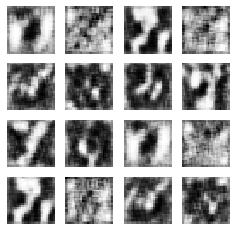

Epoch 2/1500


Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-2
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-2
tf.Tensor(0.012954338, shape=(), dtype=float32) 0.5
> no change inc: 1/5


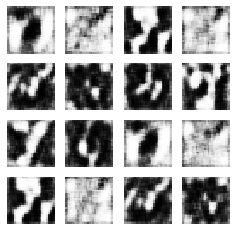

Epoch 3/1500


Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-3
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-3
tf.Tensor(0.0014354772, shape=(), dtype=float32) 0.5
> no change inc: 2/5


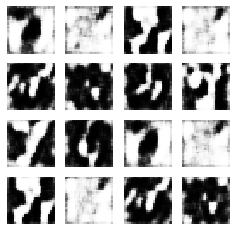

Epoch 4/1500


Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-4
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-4
tf.Tensor(0.010685428, shape=(), dtype=float32) 0.5
> no change inc: 3/5


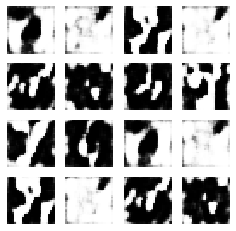

Epoch 5/1500


Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-5
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-5
tf.Tensor(0.010185675, shape=(), dtype=float32) 0.5
> no change inc: 4/5


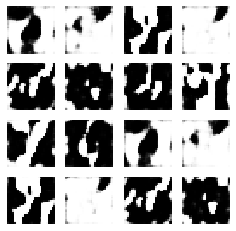

Epoch 6/1500


Saved D checkpoint: checkpoints\it_1\discriminator_checkpoint\ckpt-6
Saved G checkpoint: checkpoints\it_1\generator_checkpoint\ckpt-6
tf.Tensor(0.0028657187, shape=(), dtype=float32) 0.5
> no change inc: 5/5


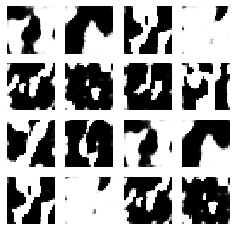

** Early stop! **

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Step 4: Training Split Learning (and gathering Black-box labels from G)
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



InvalidArgumentError: ConcatOp : Dimensions of inputs should match: shape[0] = [16,7,7,128] vs. shape[1] = [256,7,7,128] [Op:ConcatV2] name: concat

In [24]:
slg = test_entire_system()
raise Exception('...')

In [ ]:
slg = test_GAN(slg)

In [ ]:
slg.plot_gan_training()